In [670]:
# Task 1.
# Текстурные характеристики:
#  - Реализуйте подсчет гистограммы 
#  - Реализуйте рассчет текстурных характеристик Laws 
#  - Реализуйте расчет текстурных характеристик на основе матрицы взаимной встречаемости GLCM
# Для каждого случая: выполните тренировку классификатора (knn, svm, trees)
# Решите задачу сегментации данных на основе классификации изображений каждым методом.
# Выполните ручную разметку изображений на регионы.
# Сравните результат полученной классификации и размеченной.

In [671]:
import itertools
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import entropy, skew, kurtosis

from skimage.feature import graycomatrix, graycoprops
from skimage.util import view_as_windows

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, jaccard_score

## Чтение данных

In [672]:
img_fold = "./KTH_TIPS"

tex_name = os.listdir(img_fold)[3]
tex_path = os.path.join(img_fold, tex_name)

img_files = [f for f in os.listdir(tex_path)]
img_path = os.path.join(tex_path, img_files[4])
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

# Текстурные характеристики

### Подсчет и анализ гистограммы 

In [673]:
def histogram_anylyse(img, bins):
    hist = cv.calcHist([img], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    
    bin_w = 256 / bins
    centers = np.array([i * bin_w + bin_w / 2 for i in range(bins)])
    hist_norm = hist / np.sum(hist)
    
    weights = np.repeat(centers, hist.astype(int))
    
    features = {
        'mean': np.average(centers, weights=hist),
        'std': np.std(weights) if len(weights) > 0 else 0,
        'skewness': skew(weights) if len(weights) > 0 else 0,
        'kurtosis': kurtosis(weights) if len(weights) > 0 else 0,
        'entropy': entropy(hist_norm),
        'percentile_25': np.percentile(img, 25),
        'median': np.percentile(img, 50),
        'percentile_75': np.percentile(img, 75),
        'min': np.min(img),
        'max': np.max(img),
        
        'energy': np.sum(hist_norm**2),
        'variance': np.var(weights) if len(weights) > 0 else 0,
        'contrast': np.max(img) - np.min(img)
    }
    
    return features, hist_norm

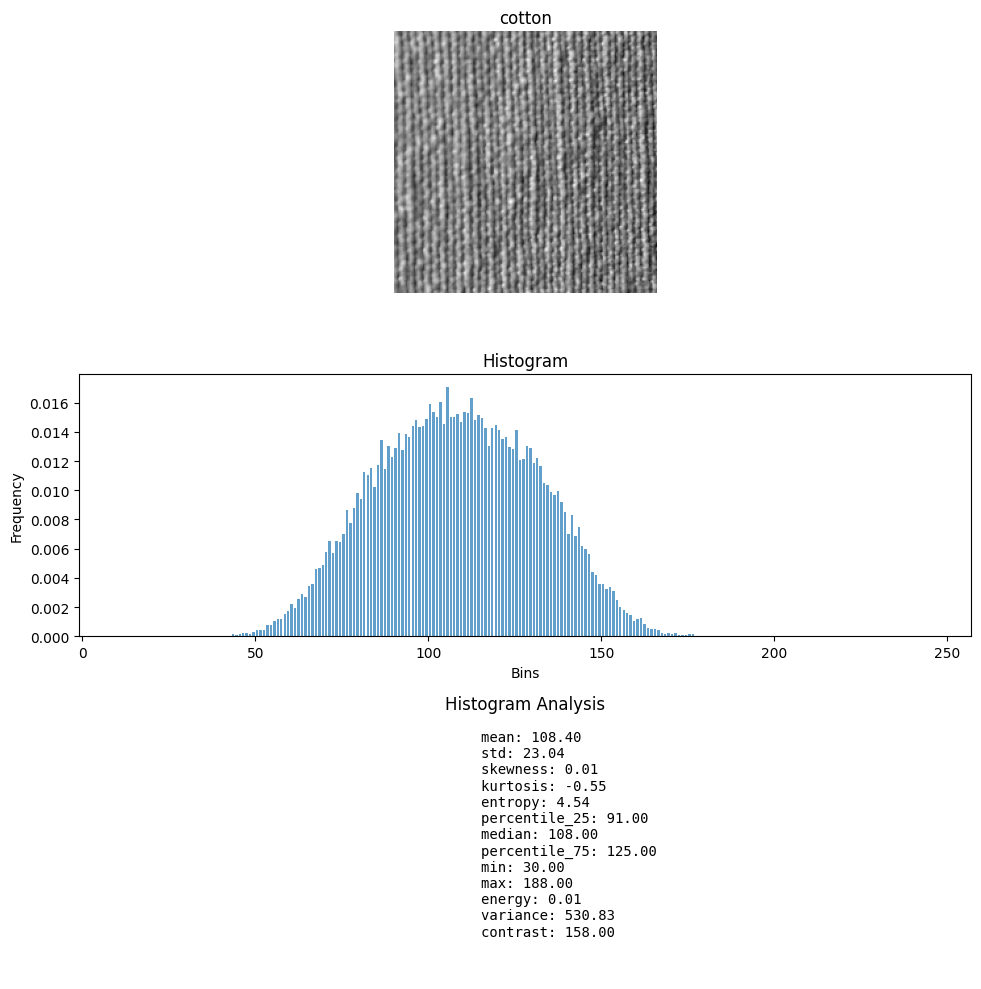

In [674]:
bins = 256
features, hist = histogram_anylyse(img, bins=bins)

bin_w = 256 / bins
bin_centers = np.array([i * bin_w + bin_w / 2 for i in range(bins)])

fig, (ax_img, ax_hist, ax_stats) = plt.subplots(3, 1, figsize=(10,10))

ax_img.imshow(img, cmap='gray')
ax_img.set_title(tex_name)
ax_img.axis('off')

bar_w = bin_w * 0.7 
ax_hist.bar(bin_centers, hist, width=bar_w, alpha=0.7)
ax_hist.set_title('Histogram')
ax_hist.set_xlabel('Bins')
ax_hist.set_ylabel('Frequency')
ax_hist.set_xlim(-1, 257)

stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in features.items()])
ax_stats.text(0.45, 0.95, stats_text, transform=ax_stats.transAxes, verticalalignment='top', family='monospace')
ax_stats.set_title('Histogram Analysis')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

### Рассчет текстурных характеристик Laws

In [675]:
def laws_texture(img):
    kernels = [
        ('L5', [1, 4, 6, 4, 1]),
        ('E5', [-1, -2, 0, 2, 1]),
        ('S5', [-1, 0, 2, 0, -1]),
        ('R5', [1, -4, 6, -4, 1]),
        ('W5', [-1, 2, 0, -2, 1])
    ]

    features_dict = {
        f"{n1}{n2}": np.mean(cv.filter2D(img.astype(np.float32), -1, 
                         np.outer(np.array(k1), np.array(k2))) ** 2)
        for (n1, k1), (n2, k2) in itertools.product(kernels, repeat=2)
    }
    
    # Normalize
    total = sum(features_dict.values())
    if total > 0:
        features_dict = {k: v/total for k, v in features_dict.items()}
    
    return features_dict

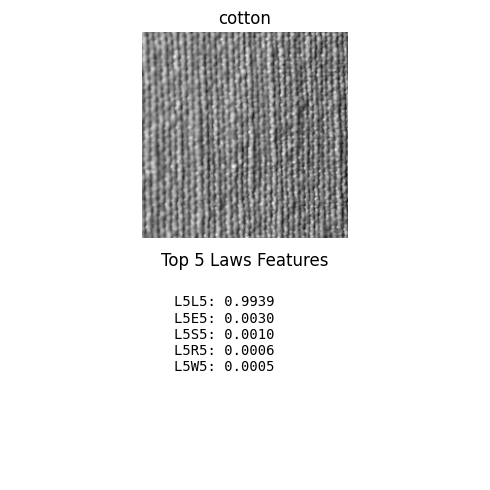

In [676]:
features_dict = laws_texture(img)

fig, (ax_img, ax_stats) = plt.subplots(2, 1, figsize=(5, 5))

ax_img.imshow(img, cmap='gray')
ax_img.set_title(tex_name)
ax_img.axis('off')

top_5 = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:5]
stats_text = '\n'.join([f'{k}: {v:.4f}' for k, v in top_5])

ax_stats.text(0.35, 0.9, stats_text, transform=ax_stats.transAxes, verticalalignment='top', family='monospace')
ax_stats.set_title('Top 5 Laws Features')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

### Расчет текстурных характеристик на основе матрицы взаимной встречаемости GLCM

In [677]:
def compute_glcm_features(img):
    glcm = graycomatrix(
        image = (img // 8).astype(np.uint8), 
        distances=[1], 
        angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4], 
        levels=32, 
        symmetric=True, 
        normed=True
    )
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM', 'mean', 'variance', 'std', 'entropy']
    features = {prop: np.mean(graycoprops(glcm, prop)) for prop in props}

    return features

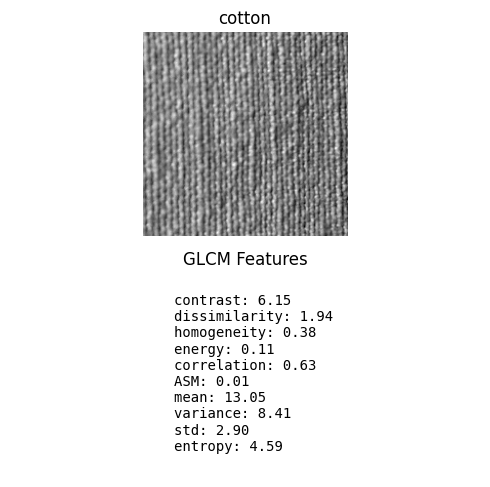

In [678]:
features = compute_glcm_features(img)

fig, (ax_img, ax_stats) = plt.subplots(2, 1, figsize=(5, 5))

ax_img.imshow(img, cmap='gray')
ax_img.set_title(tex_name)
ax_img.axis('off')

stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in features.items()])

ax_stats.text(0.35, 0.9, stats_text, transform=ax_stats.transAxes, verticalalignment='top', family='monospace')
ax_stats.set_title('GLCM Features')
ax_stats.axis('off')

plt.tight_layout()
plt.show()

# Тренировка классификаторов

## kNN

In [679]:
def prepare_dataset(img_fold, feature_type, num_imgs=100):
    features, labels = [], []
    feature_func = {
                'Histogram': lambda img: histogram_anylyse(img, 256)[0],
                'Laws': laws_texture,
                'GLCM': compute_glcm_features
    }[feature_type]

    for tex_name in os.listdir(img_fold):
        tex_path = os.path.join(img_fold, tex_name)
        if not os.path.isdir(tex_path):
            continue

        for img_file in os.listdir(tex_path)[:num_imgs]:
            img_path = os.path.join(tex_path, img_file)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

            if img is None:
                continue

            img = cv.resize(img, (128, 128))

            features_dict = feature_func(img)
            features.append(list(features_dict.values()))
            labels.append(tex_name)

    return np.array(features), labels

In [680]:
def train_models(X, y):
    y_encoded = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    classifiers = {
        'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10)
    }

    models = {name: clf.fit(X_train_scaled, y_train) for name, clf in classifiers.items()}

    return models, X_test_scaled, y_test, scaler

In [681]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test, y_pred, output_dict=True, zero_division=0
    )
    
    precision_macro = report['macro avg']['precision']
    recall_macro = report['macro avg']['recall']
    f1_macro = report['macro avg']['f1-score']
    f1_weighted = report['weighted avg']['f1-score']
    
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'accuracy': acc,
        'precision': precision_macro,
        'recall': recall_macro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm
    }

In [682]:
trained_models = {}

for feature_type in ['Histogram', 'Laws', 'GLCM']:
    print(f"Training {feature_type} models...")
    print("=" * 50)
    
    X, labels = prepare_dataset(img_fold, feature_type)
    models, X_test, y_test, scaler = train_models(X, labels)
    trained_models[feature_type] = {'models': models, 'scaler': scaler}
    
    print(f"Dataset: {X.shape} | Classes: {len(np.unique(labels))}")
    print("-" * 50)
    results = []
    for name, model in models.items():
        metrics = evaluate_model(model, X_test, y_test)
        results.append((name, metrics))
        

        print(f"{name}:")
        print(f"\tAccuracy:    {metrics['accuracy']:.3f}")
        print(f"\tPrecision:   {metrics['precision']:.3f}")
        print(f"\tRecall:      {metrics['recall']:.3f}")
        print(f"\tF1 (macro):  {metrics['f1_macro']:.3f}")
        print(f"\tF1 (weight): {metrics['f1_weighted']:.3f}")
        print()
    print("=" * 50)
    print()

Training Histogram models...
Dataset: (810, 13) | Classes: 10
--------------------------------------------------
KNN:
	Accuracy:    0.852
	Precision:   0.859
	Recall:      0.853
	F1 (macro):  0.851
	F1 (weight): 0.850

SVM:
	Accuracy:    0.837
	Precision:   0.842
	Recall:      0.839
	F1 (macro):  0.836
	F1 (weight): 0.835

DecisionTree:
	Accuracy:    0.818
	Precision:   0.826
	Recall:      0.818
	F1 (macro):  0.819
	F1 (weight): 0.818


Training Laws models...
Dataset: (810, 25) | Classes: 10
--------------------------------------------------
KNN:
	Accuracy:    0.759
	Precision:   0.779
	Recall:      0.759
	F1 (macro):  0.757
	F1 (weight): 0.757

SVM:
	Accuracy:    0.571
	Precision:   0.625
	Recall:      0.568
	F1 (macro):  0.562
	F1 (weight): 0.563

DecisionTree:
	Accuracy:    0.709
	Precision:   0.740
	Recall:      0.710
	F1 (macro):  0.710
	F1 (weight): 0.710


Training GLCM models...
Dataset: (810, 10) | Classes: 10
--------------------------------------------------
KNN:
	Accuracy:

# Задача сегментации данных на основе классификации изображений

In [683]:
def texture_segment(img, trained_models, feature_type, model_name, window_size=32, step=None, n_classes=4):
    orig_img = cv.imread(img, cv.IMREAD_GRAYSCALE)
    
    if step is None:
        step = window_size

    model = trained_models[feature_type]['models'][model_name]
    scaler = trained_models[feature_type]['scaler']
    
    # Creating sliding windows
    windows = view_as_windows(orig_img, (window_size, window_size), step=step)
    h, w, _, _ = windows.shape

    # Feature extraction for all windows
    feature_extractors = {
        'Histogram': lambda img: list(histogram_anylyse(img, bins=32)[0].values()),
        'Laws': lambda img: list(laws_texture(img).values()),
        'GLCM': lambda img: list(compute_glcm_features(img).values())
    }
    features = np.array([feature_extractors[feature_type](window) 
                         for window in windows.reshape(-1, window_size, window_size)])

    features_scaled = scaler.transform(features)
    predicts = model.predict(features_scaled)

    # Creating a segmentation map
    seg_map = np.zeros_like(orig_img)
    for (i, j), pred in zip(np.ndindex(h, w), predicts):
        seg_map[i*step:i*step+window_size, j*step:j*step+window_size] = pred

    # Filtering classes
    top_classes = pd.Series(predicts).value_counts().head(n_classes).index
    filtered_map = np.zeros_like(seg_map)
    
    for new_val, old_val in enumerate(top_classes):
        filtered_map[seg_map == old_val] = new_val
        
    # Handle pixels not in top classes
    mask_not_top = ~np.isin(seg_map, top_classes)
    if np.any(mask_not_top):
        filtered_map[mask_not_top] = 1 

    return filtered_map, orig_img


In [ ]:
def show_segment(img, trained_models, **kwargs):
    seg_map, orig = texture_segment(img, trained_models, **kwargs)
    
    fig, (ax_orig, ax_segm, ax_map) = plt.subplots(1, 3, figsize=(12, 4))
    
    ax_orig.imshow(orig, cmap='gray')
    ax_orig.set_title('Original')
    ax_orig.axis('off')
    
    ax_segm.imshow(seg_map, cmap='tab10')
    ax_segm.set_title('Segmentation')
    ax_segm.axis('off')
    
    ax_map.imshow(seg_map, cmap='tab10', alpha=0.8)
    ax_map.imshow(orig, cmap='gray', alpha=0.3)
    ax_map.set_title('Overlay')
    ax_map.axis('off')
    
    plt.tight_layout()
    plt.show()

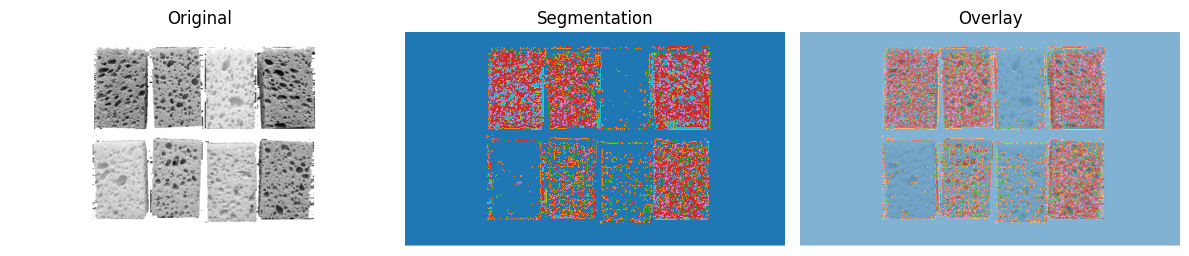

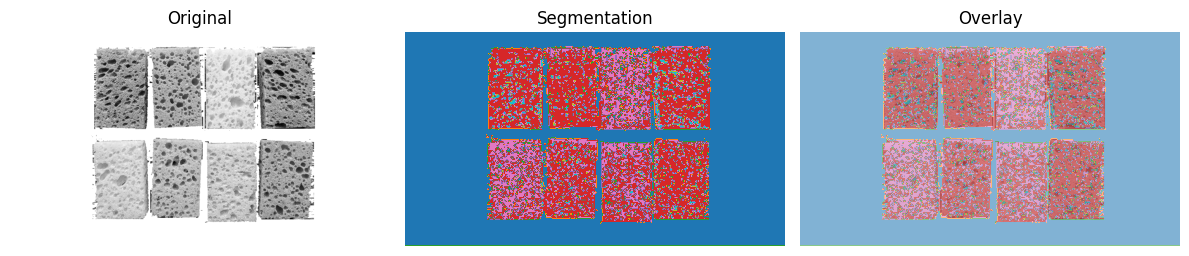

In [685]:
show_segment("./gubki.png", trained_models, window_size=4, feature_type='Laws', model_name='SVM')
show_segment("./gubki.png", trained_models, window_size=4, feature_type='GLCM', model_name='DecisionTree')

### Ручная разметка изображений на регионы

In [686]:
def manual_segment(img):
    min_channel = np.min(img, axis=2)
    _, mask = cv.threshold(min_channel, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(mask)

    for contour in contours:
        if cv.contourArea(contour) > 100:
            cv.drawContours(final_mask, [contour], 0, 255, -1)

    return final_mask

In [687]:
def remap_classes(mask, n_classes):
    unique, counts = np.unique(mask, return_counts=True)
    top_classes = unique[np.argsort(-counts)[:n_classes]]

    result = np.zeros_like(mask)
    for new_id, old_id in enumerate(top_classes):
        result[mask == old_id] = new_id

    return result

In [688]:
img_path = "./gubki.png"
img = cv.imread(img_path)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

manual_mask = manual_segment(img_rgb)
manual_mask = remap_classes(manual_mask, 4)

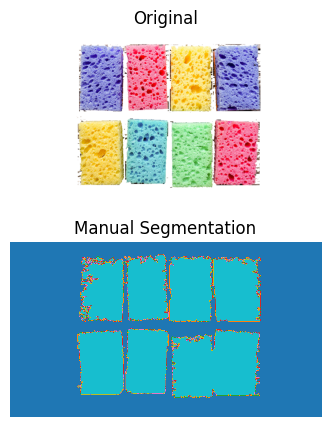

In [689]:
fig, (ax_orig, ax_segm) = plt.subplots(2, 1, figsize=(5, 5))

ax_orig.imshow(img_rgb)
ax_orig.set_title('Original')
ax_orig.axis('off')

ax_segm.imshow(manual_mask, cmap='tab10')
ax_segm.set_title('Manual Segmentation')
ax_segm.axis('off')

plt.show()

## Сравнение результатов полученной классификации с размеченной.

In [690]:
def find_class_mapping(true_mask, pred_mask):
    true_flat = true_mask.flatten()
    pred_flat = pred_mask.flatten()
    
    true_classes = np.unique(true_flat)
    pred_classes = np.unique(pred_flat)

    mapping = {}
    for pred_class in pred_classes:
        best_overlap = -1
        best_true_class = None
        
        for true_class in true_classes:
            overlap = np.sum((true_flat == true_class) & (pred_flat == pred_class))
            
            if overlap > best_overlap:
                best_overlap = overlap
                best_true_class = true_class
        
        mapping[pred_class] = best_true_class
    
    return mapping


def compare_segment_results(manual_mask, predicted_mask, orig_img):
    if manual_mask.shape != predicted_mask.shape:
        predicted_mask = cv.resize(predicted_mask,
                                   (manual_mask.shape[1], manual_mask.shape[0]),
                                   interpolation=cv.INTER_NEAREST)

    class_mapping =  find_class_mapping(manual_mask, predicted_mask)
    pred_map = np.zeros_like(predicted_mask)
    
    for pred_class, true_class in class_mapping.items():
        pred_map[predicted_mask == pred_class] = true_class

    flat_true = manual_mask.flatten()
    flat_pred = pred_map.flatten()

    accuracy = accuracy_score(flat_true, flat_pred)
    iou_scores = jaccard_score(flat_true, flat_pred, 
                              average=None, labels=np.unique(manual_mask))
    
    print(f"Accuracy: {accuracy:.1%}")
    
    print("IoU per class:")
    for i, class_id in enumerate(np.unique(manual_mask)):
        print(f"  Class {class_id}: {iou_scores[i]:.3f}")
    
    fig, (ax_orig, ax_manual, ax_pred) = plt.subplots(3, 1, figsize=(10, 10))
    
    ax_orig.imshow(orig_img, cmap='gray')
    ax_orig.set_title('Original')
    ax_orig.axis('off')
    
    ax_manual.imshow(manual_mask, cmap='tab10')
    ax_manual.set_title('Manual Mask')
    ax_manual.axis('off')
    
    ax_pred.imshow(pred_map, cmap='tab10')
    ax_pred.set_title('Predicted Mask')
    ax_pred.axis('off')
    
    plt.tight_layout()
    plt.show()

GLCM - DecisionTree
--------------------------------------------------
Accuracy: 93.9%
IoU per class:
  Class 0: 0.905
  Class 1: 0.857


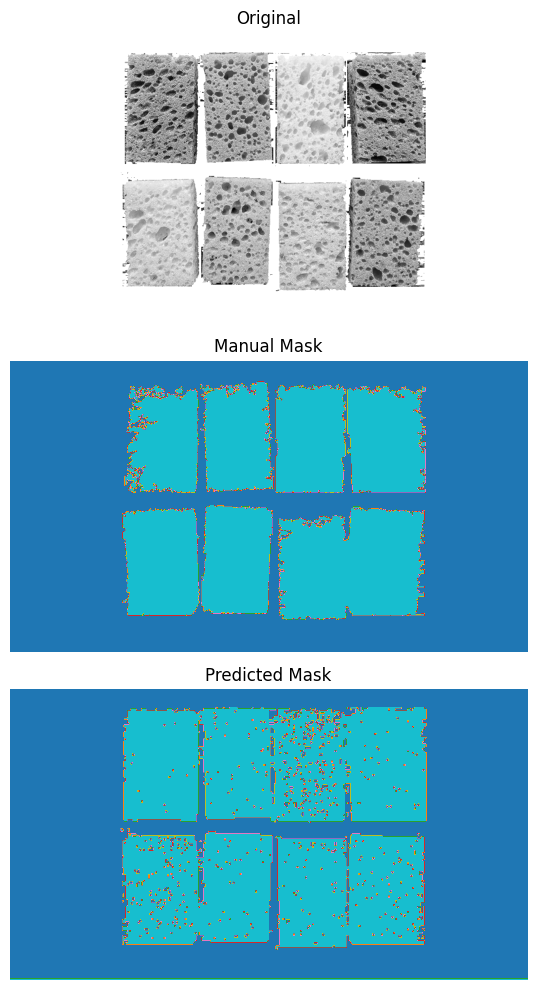

In [691]:
feature_type = 'GLCM'
model_name = 'DecisionTree'
print("=" * 50)
print(f"{feature_type} - {model_name}")
print("-" * 50)
predicted_mask, _ = texture_segment(
    img_path, 
    trained_models,
    window_size=4, 
    feature_type=feature_type, 
    model_name=model_name
)

img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
compare_segment_results(manual_mask, predicted_mask, img)